In [1]:
import warnings
import gzip
import ujson

import pandas as pd

from glob import glob
from itertools import islice
from tqdm import tqdm

from news_vec import logger

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')

In [4]:
class Line:

    def __init__(self, tokens, label, lower=True):
        self.tokens = [t.lower() for t in tokens] if lower else tokens
        self.label = label

    def __repr__(self):

        pattern = '{cls_name}<{token_count} tokens -> {label}>'

        return pattern.format(
            cls_name=self.__class__.__name__,
            token_count=len(self.tokens),
            label=self.label,
        )

In [5]:
def read_json_lines(root, lower=True):
    """Generate links from a JSON corpus.

    Yields: list<str>
    """
    for path in glob('%s/*.gz' % root):
        with gzip.open(path) as fh:
            for line in fh:

                data = ujson.loads(line)

                tokens = data.get('tokens')

                if not tokens:
                    continue

                yield Line(tokens, data['label'], lower=lower)

In [6]:
class Corpus:

    def __init__(self, root, skim=None, lower=True):
        """Read lines.
        """
        logger.info('Parsing line corpus.')

        lines_iter = islice(read_json_lines(root, lower), skim)

        self.lines = list(tqdm(lines_iter))

    def __repr__(self):

        pattern = '{cls_name}<{line_count} lines>'

        return pattern.format(
            cls_name=self.__class__.__name__,
            line_count=len(self),
        )

    def __len__(self):
        return len(self.lines)

    def __iter__(self):
        return iter(self.lines)

In [7]:
c = Corpus('../data/titles-50k.json/')

2018-11-27 19:26:57,573 | INFO : Parsing line corpus.
2123078it [00:23, 90858.38it/s] 


In [8]:
data = [
    (line.label, len(line.tokens))
    for line in c
    if len(line.tokens) < 30
]

df = pd.DataFrame(data, columns=('domain', 'words'))

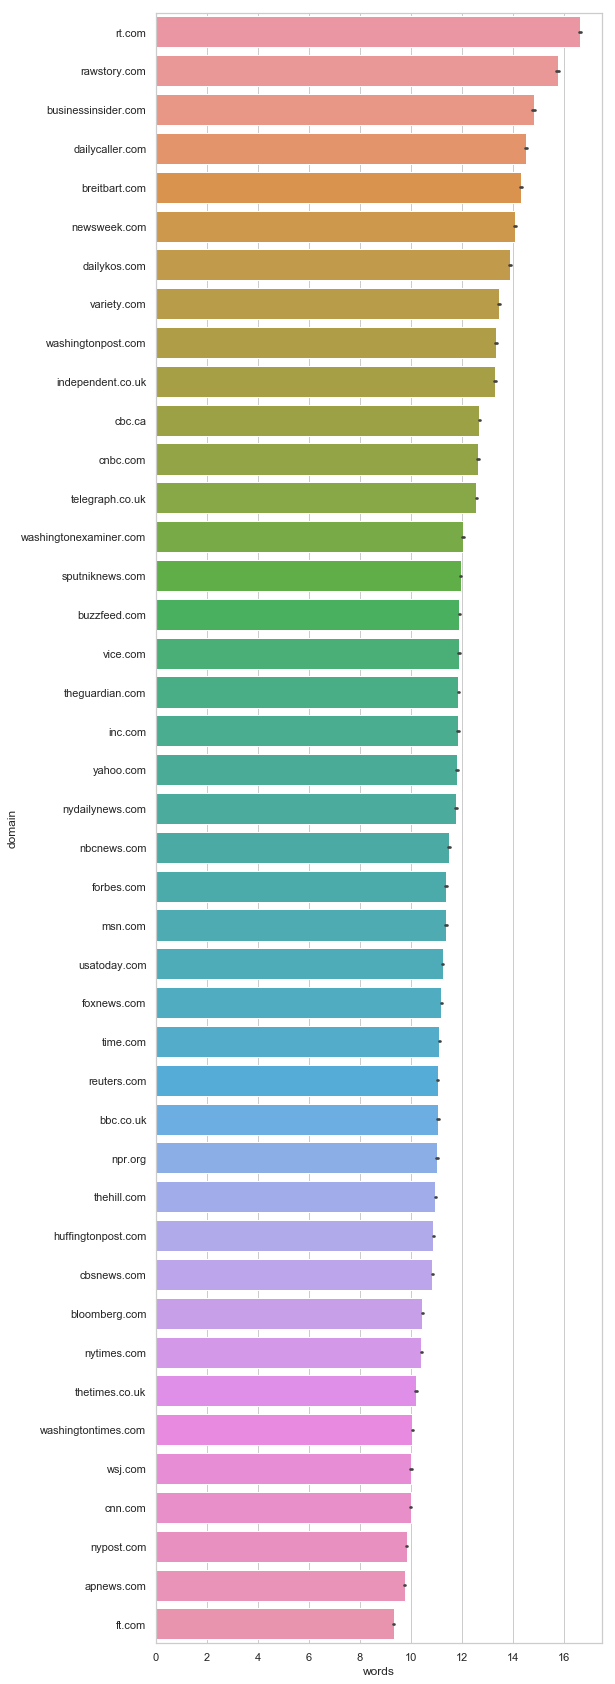

In [9]:
order = df.groupby('domain').mean().sort_values('words', ascending=False).index
plt.figure(figsize=(8,30))
sns.barplot(x='words', y='domain', data=df, order=order)

In [10]:
data = [
    (line.label, len(token))
    for line in c
    for token in line.tokens
    if len(token) < 20
]

df = pd.DataFrame(data, columns=('domain', 'chars'))

In [14]:
len(df)

25356460

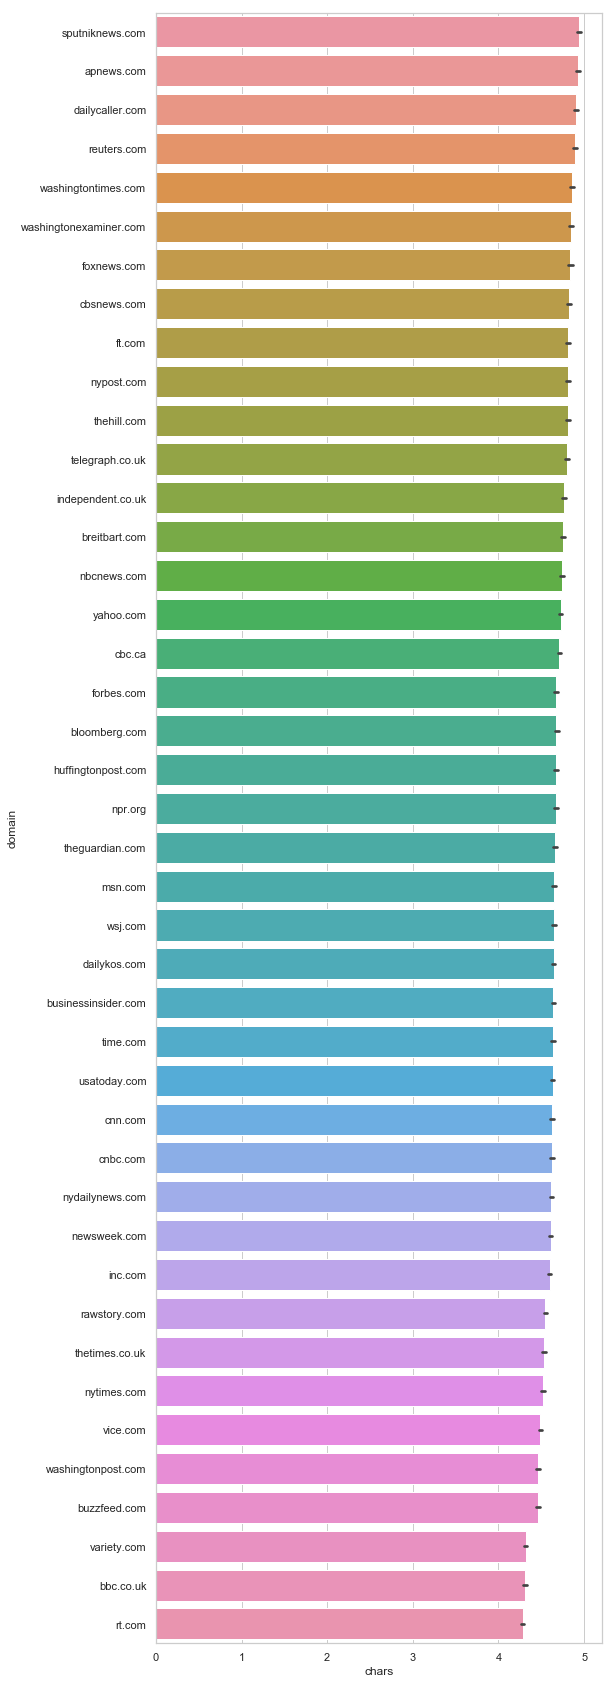

In [15]:
sdf = df.sample(frac=0.1)
order = sdf.groupby('domain').mean().sort_values('chars', ascending=False).index
plt.figure(figsize=(8,30))
sns.barplot(x='chars', y='domain', data=sdf, order=order)